# Heart Failure Clinical Records
This notebook will perform some essential EDA and cleaning for the input data.  The data will be exported after it has been cleaned to be used in the model.

## Introduction

The data comes from the [UCL Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#).  It contains medical records of 299 patients who had heart failure and consists of 13 clinical features.  There is also an [academic paper](https://doi.org/10.1186/s12911-020-1023-5) associated with this data, which is in fact based upon an [older paper](https://doi.org/10.1371/journal.pone.0181001).  Both of these papers provide significant detail about what the clinical features mean.

In this case, the challenge is to predict the `DEATH_EVENT` of a patient as a boolean (in the form of `0` or `1`).  The complete features present in the data are:

* `age` — Age of the patient (years).
* `anaemia` — Decrease of red blood cells or hemoglobin (boolean).
* `high_blood_pressure` — If the patient has hypertension (boolean).
* `creatinine_phosphokinase` — Level of the CPK enzyme in the blood (mcg/L).
* `diabetes` — If the patient has diabetes (boolean).
* `ejection_fraction` — Percentage of blood leaving the heart at each contraction (percentage/100).
* `platelets` — Platelets in the blood (kiloplatelets/mL).
* `sex` — Woman or man (binary).
* `serum_creatinine` — Level of serum creatinine in the blood (mg/dL).
* `serum_sodium` — Level of serum sodium in the blood (mEq/L).
* `smoking` — If the patient smokes or not (boolean).
* `time` — Follow-up period (days).
* `DEATH_EVENT` — If the patient deceased during the follow-up period (boolean).

The newer paper that this data is based upon suggests that using only `ejection_fraction` and `serum_creatinine` can result in an accuracy of ~0.838 (among other measurements).

## Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

all_data = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')

## Data Overview
Let's firstly have a browse of the data just to see what is present.

In [2]:
all_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Sanity Checks

Before we continue or make any changes, let's check for any duplicate rows.  Luckily, there are none!

In [3]:
all_data[all_data.duplicated()]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


Let's also check for any missing values that may need to be investigated and fixed (imputing or investigated for removal).  We're lucky again that there are none.

In [4]:
print(f'Total rows with a null element: {sum(all_data.isnull().any(1))}')

Total rows with a null element: 0


## Data Types
So the data has no duplicates or missing values, which is great.  Let's now check the data types for each column based on the accompanying paper's explanation and fix any that come up.

Pandas, by default, uses 64-bit values (`int64`, `float64`, etc.).  We could go about reducing the size of these to save memory, but realistically given the small size of this dataset, it's really not worth doing.

Of the below, the two that concern me are `age` and `platelets`.  The former should definitely be an integer, so something is wrong there.  The latter, looking at the brief dataframe print earlier, could be mostly rounded with a few exceptions; this is worth looking into.

In [5]:
all_data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

### Age
Starting with `age`, we can check what elements are not an integer to see how many are off.

In [6]:
all_data[all_data['age'].map(lambda x: not x.is_integer())]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
185,60.667,1,104,1,30,0,389000.0,1.5,136,1,0,171,1
188,60.667,1,151,1,40,1,201000.0,1.0,136,0,0,172,0


It appears that two values are decimals, so it's likely an input error.  Given that they are so few in number, it's worth just rounding them up and converting the column to be an `int64`.

In [7]:
all_data['age'] = all_data['age'].round(0).astype(np.int64)

In [8]:
print(f'The age column is now: {all_data.age.dtype}')

# Check the above two values that were floats before.
print(f'Entry 185 is now {all_data.age.iloc[185]}')
print(f'Entry 188 is now {all_data.age.iloc[188]}')

The age column is now: int64
Entry 185 is now 61
Entry 188 is now 61


### Platelets
Now let's deal with the `platelets` column.  From my very limited knowledge of platelet measurements, decimal places don't seem to be used.  Let's have a browse of all non-integer values in that column.

In [9]:
float_platelets = all_data[all_data['platelets'].map(lambda x: not x.is_integer())]['platelets']

print(f'Total number of float platelets: {len(float_platelets)}')
print(f'Unique float platelet values: {float_platelets.unique()}')

Total number of float platelets: 25
Unique float platelet values: [263358.03]


Given that the majority of values are integers, that all 25 of the float values are identical, and that the deviation of these float values is *really* close to an integer, it's fairly safe to round and convert just like `age`.  From what I can see, both the old and new paper don't mention this.

In [10]:
all_data['platelets'] = all_data['platelets'].round(0).astype(np.int64)

In [11]:
print(f'The platelets column is now: {all_data.platelets.dtype}')

The platelets column is now: int64


## Data Ranges
The paper that this data comes with describes the ranges within which the data falls.  Let's have a look at the ranges and see if they match.

In [12]:
# Could also do this by hand, but whatever.
all_data.describe().drop(['mean', 'std', '25%', '50%', '75%'])

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0,299.0
min,40.0,0.0,23.0,0.0,14.0,0.0,25100.0,0.5,113.0,0.0,0.0,4.0,0.0
max,95.0,1.0,7861.0,1.0,80.0,1.0,850000.0,9.4,148.0,1.0,1.0,285.0,1.0


Of these, `serum_sodium` is listed as having a minimum of `114`, but here it's `113`.  I cannot see this being an issue and it's likely a misreporting, so I'll leave that unchanged.

They have also converted `platelets` by multiplying it by `0.001`, likely to either have the units in a different scale or to bring it closer to the other variables.  Regardless, I'll do the same.

In [13]:
all_data['platelets'] = all_data['platelets'] * 0.001

## Skewness
Since many outlier detection algorithms are susceptible to skewed datasets, let's firstly see if any of the data needs to be transformed due to being too skewed.  Typically, anything within `+/- 0.5` is acceptable, up to `+/- 1.0` is moderately skewed, and anything over `+/- 1.0` is highly skewed.  We can view these with histograms or by calculating the skew.

Any transformations made here will have to be made to new input data to the machine learning model too.

Let's begin by identifying any columns that are a little too high.

In [14]:
# Arbitrarily chosen. Medium skewness is worth investigating.
skew_threshold = 0.7

# Compute the skewness for all columns except the target and any known booleans.
skew_drop = ['anaemia', 'high_blood_pressure', 'diabetes', 'sex', 'smoking', 'DEATH_EVENT']
skewed_df = all_data.drop(skew_drop, axis=1).skew().sort_values(ascending=False)
skewed_df = skewed_df[(skewed_df > skew_threshold) | (skewed_df < -skew_threshold)]
skewed_df

creatinine_phosphokinase    4.463110
serum_creatinine            4.455996
platelets                   1.462321
serum_sodium               -1.048136
dtype: float64

There are a few listed above, so let's view them, scale them with a `boxcox`, and then view them again.  Note that with `boxcox`, the data *must* be positive, but it generally gives better results than `sqrt` or `log`.

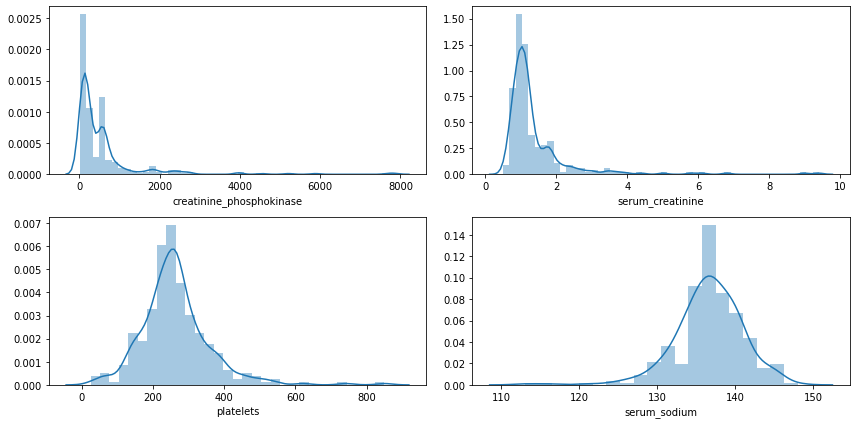

In [15]:
skew_fig = plt.figure(figsize=(12,6))
for i in range(1, len(skewed_df)+1):
    skew_fig.add_subplot(2, 2, i)
    col = skewed_df.index[i-1]
    sns.distplot(all_data[col])
skew_fig.tight_layout()
plt.show()

In [16]:
# Log all of the skewed columns in the original dataset.
for col in skewed_df.index:
    all_data[col] = stats.boxcox(all_data[col])[0]

Now that the columns have been unskewed, the skewness looks much better!  In fact, `boxcox` made them almost normal!

In [17]:
for col in skewed_df.index:
    skew_val = all_data[col].skew()
    print(f'{col} skew: {skew_val}')

creatinine_phosphokinase skew: 0.04263757498771911
serum_creatinine skew: 0.02135286185510907
platelets skew: 0.155362575364432
serum_sodium skew: 0.08235851661168656


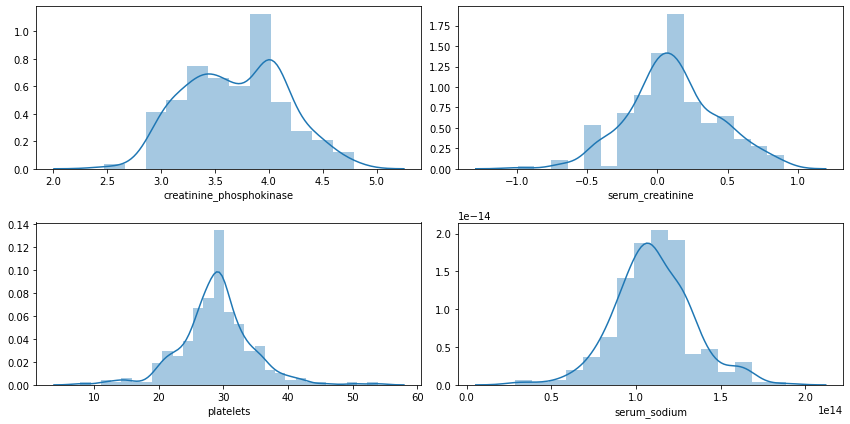

In [18]:
skew_fig = plt.figure(figsize=(12,6))
for i in range(1, len(skewed_df)+1):
    skew_fig.add_subplot(2, 2, i)
    col = skewed_df.index[i-1]
    sns.distplot(all_data[col])
skew_fig.tight_layout()
plt.show()

# TODO
* Investigate any outliers.
* Balance of data for target variable.
* Correlation investigation for potential feature selection.